*Что делаем сейчас* :
1. Делаем цикл что бы все инструменты прогнать чз стратегию


In [1]:
import pandas as pd
import plotly.graph_objects as go
from datetime import timedelta
import yfinance as yf
# from pandas_datareader import data as pdr
# yf.pdr_override() # <== that's all it takes :-)


In [2]:
# Загрузка и подготовка данных из загруженного файла
# в файле дневки за 3 года все акции NYSE около 2500
df = pd.read_parquet('stock_history_20_11_23.parquet')


In [510]:
# Загрузка данных через yfinance
# df = yf.download("algn", start="2019-12-10", interval = "1d")
# download dataframe
# saved_data = pdr.get_data_yahoo("AAPL", start="2017-01-01", end="2017-04-30")

[*********************100%***********************]  1 of 1 completed


In [511]:
# тянем из набора конкретную акцию
# df = saved_data['TAL']
# Форматирование столбца 2 знака после запятой
# df['Close'] = df['Adj Close'].round(2)
# df['Open'] = df['Open'].round(2)
# df['Close'] = df['Adj Close'].round(2)
# df['High'] = df['High'].round(2)
# df['Low'] = df['Low'].round(2)
# df.dropna(inplace=True)

***Индикаторы***

In [ ]:
# Индикаторы

# рассчет Donchian channel
donchian_period = 100
df['high_100'] = df['High'].rolling(window=donchian_period).max()
df['low_100'] = df['Low'].rolling(window=donchian_period).min()
df['mid_ch'] = (df['high_100'] +df['low_100']) / 2
# --------------------------------------------------------------------------------------
# рассчет Donchian channel адаптированный по волатильности
# Расчет волатильности (стандартное отклонение цен закрытия за последние 20 дней)
df['Volatility'] = df['Close'].rolling(window=20).std()

# Среднее стандартное отклонение
mean_volatility = df['Volatility'].mean()*-1.5

# Функция для определения периода Donchian Channel
def determine_donchian_period(row):
    if row['Volatility'] > mean_volatility:
        return 100
    else:
        return 100
    
# Применение функции к DataFrame
df['Donchian_Period'] = df.apply(determine_donchian_period, axis=1)
# print(df.head())
# Расчет Donchian Channel адаптивный
for i in range(len(df)):
    period = int(df.iloc[i]['Donchian_Period'])
    if i >= period:
        df.at[df.index[i], 'Donchian_Upper'] = df['High'][i-period:i].max()
        df.at[df.index[i], 'Donchian_Lower'] = df['Low'][i-period:i].min()

# Добавляем среднюю линию Donchian Channel
df['Donchian_Middle'] = (df['Donchian_Upper'] + df['Donchian_Lower']) / 2
# ---------------------------------------------------------------------------------------
# SMA
sma_period = 10
df['SMA'] = df['Close'].rolling(window=sma_period).mean()

# df = df.dropna(subset=['mid_ch']) # выбрасываем из фрэйма все значения NAn из индикатора с большим периодом
df.head()

,Open,High,Low,Close,Adj Close,Volume,high_100,low_100,mid_ch,Volatility,Donchian_Period,Donchian_Upper,Donchian_Lower,Donchian_Middle,SMA
Date,,,,,,,,,,,,,,,
2019-12-09,275.209991,277.209991,273.179993,273.459991,273.459991,456400,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN
2019-12-10,273.049988,274.160004,269.500000,273.649994,273.649994,490800,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN
2019-12-11,273.850006,278.929993,273.130005,275.230011,275.230011,539700,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN
2019-12-12,275.899994,276.339996,266.290009,268.390015,268.390015,915300,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN
2019-12-13,268.149994,268.149994,257.429993,266.059998,266.059998,1011700,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN


In [ ]:
# Определение точек входа и выхода
df['entry_signal'] = (
    (df['Close'] > df['Donchian_Middle']) &
    (df['Close'].shift(1) < df['Donchian_Middle'].shift(1)) & 
    (df['Close'].shift(2) < df['Donchian_Middle'].shift(2))
)

df['tp_signal'] = (
    (df['Close'] < df['SMA']) &
    (df['Close'].shift(1) < df['SMA'].shift(1))
    )


df

,Open,High,Low,Close,Adj Close,Volume,high_100,low_100,mid_ch,Volatility,Donchian_Period,Donchian_Upper,Donchian_Lower,Donchian_Middle,SMA,entry_signal,tp_signal
Date,,,,,,,,,,,,,,,,,
2019-12-09,275.209991,277.209991,273.179993,273.459991,273.459991,456400,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,False,False
2019-12-10,273.049988,274.160004,269.500000,273.649994,273.649994,490800,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,False,False
2019-12-11,273.850006,278.929993,273.130005,275.230011,275.230011,539700,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,False,False
2019-12-12,275.899994,276.339996,266.290009,268.390015,268.390015,915300,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,False,False
2019-12-13,268.149994,268.149994,257.429993,266.059998,266.059998,1011700,NaN,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,209.610001,212.979996,202.600006,203.119995,203.119995,1269200,413.200012,176.339996,294.770004,29.518017,50,367.709991,176.339996,272.024994,196.794,False,False
2023-11-17,204.509995,208.130005,203.000000,206.639999,206.639999,1068900,413.200012,176.339996,294.770004,25.619794,50,342.000000,176.339996,259.169998,197.714,False,False
2023-11-20,206.100006,216.029999,206.100006,215.240005,215.240005,1292900,413.200012,176.339996,294.770004,21.398592,50,336.109985,176.339996,256.224991,199.461,False,False


In [ ]:
# Расчет стоп-лосса и тейк-профита
df['stop_loss'] = (df['Donchian_Middle'] - df['Donchian_Middle'] * 0.01).round(2)
# df['take_profit'] = (df['Open'] * 1.06).round(2)
# df['take_profit'] = (df['Open'] * 1.06).round(2)
df['shifted_entry_signal'] = df['entry_signal'].shift(1) #создаем строку что бы входить по не на следующем open  а не по close



In [ ]:
# Функция запуска торговой стратегии
def test_trading_strategy(data):
    in_position = False
    entry_price = None
    stop_loss_price = None
    take_profit_signal = None
    trades = []

    for index, row in data.iterrows():
        if in_position:
            if row['Close'] < row['stop_loss'] or row['tp_signal']:
                trades.append({'date': index, 'price': row['Close'], 'type': 'sell', 'tp': row['Close']}) 
                in_position = False
        else:
            if row['shifted_entry_signal']:
                entry_price = row['Open']
                stop_loss_price = row['stop_loss']
                # take_profit_price = row['Open'] * 1.1
            
                trades.append({'date': index, 'price': entry_price, 'type': 'buy', 'sl': stop_loss_price, 
                            #    'tp': take_profit_price
                               })
                in_position = True
    trades.pop(0)
    trades.pop(0)

    return trades

# Применение стратегии и получение сделок
trades = test_trading_strategy(df)


In [ ]:
# График обычног канала
# fig = go.Figure(data=[go.Candlestick(x=df.index,
#                 open=df['Open'],
#                 high=df['High'],
#                 low=df['Low'],
#                 close=df['Close'])])

# # Добавление средней линии канала Дончиана
# fig.add_trace(go.Scatter(x=df.index, y=df['mid_ch'], mode='lines', name='Donchian Mid Channel', line=dict(color='orange', width=2)))
# # Добавление SMA
# fig.add_trace(go.Scatter(x=df.index, y=df['SMA'], mode='lines', name='SMA', line=dict(color='blue', width=2)))

# # Определение интервала для создания "ширины" линий Stop Loss и Take Profit
# time_delta = timedelta(days=1)

# # Добавление точек сделок
# for trade in trades:

#     # trade_date = pd.to_datetime(trade['date'])
#     start_time = trade['date'] - time_delta
#     end_time = trade['date'] + time_delta

#     fig.add_trace(go.Scatter(
#         x=[trade['date']], y=[trade['price']], mode='markers', 
#         marker_symbol='circle', marker_line_color='black', 
#         marker_color='green' if trade['type'] == 'buy' else 'red', 
#         marker_line_width=2, marker_size=10, 
#         name=f"{trade['type'].title()} @ {trade['price']}"
#     ))

#     # Если это сделка на покупку, добавляем стоп-лосс и тейк-профит
#     if trade['type'] == 'buy':
#         # Добавление стоп-лосса
#         # print(trade['date'])
#         fig.add_trace(go.Scatter(
#             x=[start_time, end_time], 
#             y=[trade['sl'], trade['sl']], 
#             mode='lines', 
#             line=dict(color='red', width=3, dash='dash'), 
#             name='Stop Loss'
#         ))
#         # Добавление тейк-профита
#         # fig.add_trace(go.Scatter(
#         #     x=[start_time, end_time], 
#         #     y=[trade['tp'], trade['tp']], 
#         #     mode='lines', 
#         #     line=dict(color='green', width=3, dash='dash'), 
#         #     name='Take Profit'
#         # ))

# # Настройки графика
# fig.update_layout(
#     title='Trading Strategy Performance', 
#     xaxis_title='Date', 
#     yaxis_title='Price', 
#     legend_title='Legend', 
#     template='plotly_dark',
#     autosize=False,
#     width=1500,
#     height=800,
#     xaxis_rangeslider_visible=False,
#     margin=dict(
#         l=10,
#         r=10,
#         b=20,
#         t=50,
#         pad=1,),
# )

# fig.show()
# # Сохранение графика в файл
# # plot_file_path = '/mnt/data/spy_trading_strategy_updated.html'
# # fig.write_html(plot_file_path)



In [ ]:
#График адаптированного канала 
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

# Добавление средней линии канала Дончиана
fig.add_trace(go.Scatter(x=df.index, y=df['Donchian_Middle'], mode='lines', name='Donchian Adapted Channel', line=dict(color='orange', width=2)))
# Добавление SMA
fig.add_trace(go.Scatter(x=df.index, y=df['SMA'], mode='lines', name='SMA', line=dict(color='blue', width=2)))

# Определение интервала для создания "ширины" линий Stop Loss и Take Profit
time_delta = timedelta(days=1)

# Добавление точек сделок
for trade in trades:

    # trade_date = pd.to_datetime(trade['date'])
    start_time = trade['date'] - time_delta
    end_time = trade['date'] + time_delta

    fig.add_trace(go.Scatter(
        x=[trade['date']], y=[trade['price']], mode='markers', 
        marker_symbol='circle', marker_line_color='black', 
        marker_color='green' if trade['type'] == 'buy' else 'red', 
        marker_line_width=2, marker_size=10, 
        name=f"{trade['type'].title()} @ {trade['price']}"
    ))

    # Если это сделка на покупку, добавляем стоп-лосс и тейк-профит
    if trade['type'] == 'buy':
        # Добавление стоп-лосса
        # print(trade['date'])
        fig.add_trace(go.Scatter(
            x=[start_time, end_time], 
            y=[trade['sl'], trade['sl']], 
            mode='lines', 
            line=dict(color='red', width=3, dash='dash'), 
            name='Stop Loss'
        ))
        # Добавление тейк-профита
        # fig.add_trace(go.Scatter(
        #     x=[start_time, end_time], 
        #     y=[trade['tp'], trade['tp']], 
        #     mode='lines', 
        #     line=dict(color='green', width=3, dash='dash'), 
        #     name='Take Profit'
        # ))

# Настройки графика
fig.update_layout(
    title='Trading Strategy Performance', 
    xaxis_title='Date', 
    yaxis_title='Price', 
    legend_title='Legend', 
    template='plotly_dark',
    autosize=False,
    width=1500,
    height=800,
    xaxis_rangeslider_visible=False,
    margin=dict(
        l=10,
        r=10,
        b=20,
        t=50,
        pad=1,),
)

fig.show()
# Сохранение графика в файл
# plot_file_path = '/mnt/data/spy_trading_strategy_updated.html'
# fig.write_html(plot_file_path)



In [ ]:
# Расчет статистики по сделкам

# Подготовка данных для анализа
trades_df = pd.DataFrame(trades)

# Разделяем сделки на покупки и продажи
buy_trades = trades_df[trades_df['type'] == 'buy']
sell_trades = trades_df[trades_df['type'] == 'sell']

# Количество сделок
total_trades = len(trades)
buy_trades_count = len(buy_trades)
sell_trades_count = len(sell_trades)

# Прибыльность сделок
# Для этого нужно сопоставить каждую покупку с последующей продажей
profits = []
for i in range(buy_trades_count):
    if i < sell_trades_count:  # Проверка, чтобы избежать выхода за пределы списка
        buy_price = buy_trades.iloc[i]['price']
        sell_price = sell_trades.iloc[i]['price']
        profit = sell_price - buy_price
        profits.append(profit)

# Расчет средней прибыли и других статистик
total_profit_loss = sum(profits)  # Общая прибыль/убыток
average_profit = sum(profits) / len(profits) if profits else 0
max_profit = max(profits) if profits else 0
min_profit = min(profits) if profits else 0
positive_trades = len([p for p in profits if p > 0])
negative_trades = len([p for p in profits if p < 0])


# Статистика
{   
    "total_profit_loss": total_profit_loss,
    "total_trades": total_trades,
    "buy_trades": buy_trades_count,
    "sell_trades": sell_trades_count,
    "average_profit": (average_profit).round(2),
    "max_profit": (max_profit).round(2),
    "min_profit": (min_profit).round(2),
    "positive_trades": positive_trades,
    "negative_trades": negative_trades
}
# trades_df

{'total_profit_loss': -8.2099609375,
 'total_trades': 26,
 'buy_trades': 13,
 'sell_trades': 13,
 'average_profit': -0.63,
 'max_profit': 114.43,
 'min_profit': -40.36,
 'positive_trades': 5,
 'negative_trades': 8}

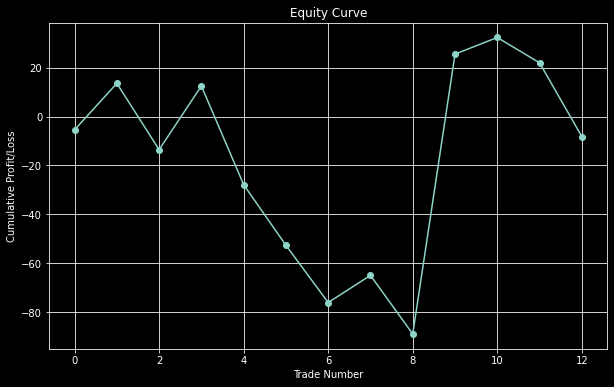

In [ ]:
import matplotlib.pyplot as plt

# Кумулятивная сумма прибыли/убытка
cumulative_profit = pd.Series(profits).cumsum()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(cumulative_profit, marker='o', linestyle='-')
plt.title('Equity Curve')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.show()
